# What is saliency?

Saliency refers to methods that highlight the most important input features influencing a model's output. In neural networks, saliency maps show which parts of an input, like image regions or text, contribute most to the model's decision. This helps in interpreting the model’s reasoning and evaluating its alignment with human expectations.


 Download these each seperatly through pip
- pip install torch torchvision matplotlib grad-cam
- pip install timm
- pip install "numpy<2"

## Based on this image, what key characteristics or features would you consider the most important for identifying the object, such as determining if it's a cat, dog, horse, etc.?

Files already downloaded and verified


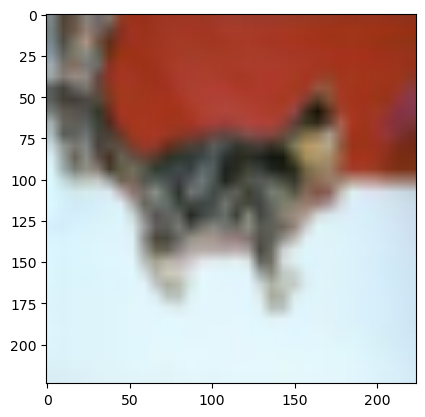

In [119]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Sample image
dataiter = iter(test_loader)
images, labels = next(dataiter)


# Display the image
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.show()



# When analyzing how a model makes its decision, if you've ever wanted to visualize the weight of influences:

    - Red: Indicates areas with the strongest influence on the model's prediction.
    - Orange/Yellow: Reflects regions with moderate influence on the decision.
    - Green: Highlights areas with low influence on the prediction.
    - Blue: Shows regions with minimal to no influence on the model’s outcome.

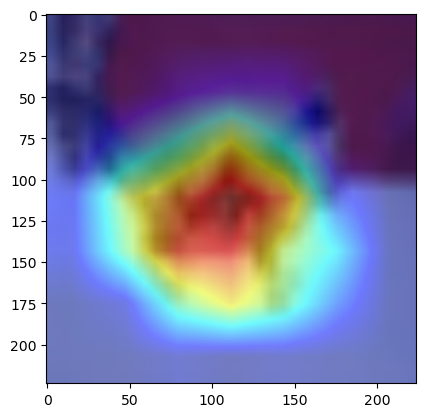

In [121]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

# generate saliency map using Grad-CAM
def generate_gradcam(input_image, model, target_class=None):
    target_layers = [model.layer4[-1]]  # Layer to visualize
    cam = GradCAM(model=model, target_layers=target_layers)  # Removed use_cuda argument
    
    # generate saliency map
    grayscale_cam = cam(input_tensor=input_image, targets=[ClassifierOutputTarget(target_class)])
    return grayscale_cam[0]

# visualize saliency map
saliency_map = generate_gradcam(images, model, labels[0].item())
image_np = np.transpose(images[0].numpy(), (1, 2, 0))
cam_image = show_cam_on_image(image_np, saliency_map, use_rgb=True)

# display the saliency map
plt.imshow(cam_image)
plt.show()


### **Ground Truth Coverage (GTC)**:
- **Definition**: Measures how much of the human-labeled ground truth is covered by the model’s salient features.
- **Calculation**: 
  GTC = |G ∩ S| / |G|
  - G = Ground truth feature set.
  - S = Saliency feature set.
- **Usage**: Indicates how well the model relies on relevant, human-annotated features.

### **Saliency Coverage (SC)**:
- **Definition**: Measures how much of the model’s salient features overlap with the human-labeled ground truth.
- **Calculation**: 
  SC = |G ∩ S| / |S|
- **Usage**: Shows how much the model’s decision is based on features relevant to human understanding.

### **Intersection over Union (IoU)**:
- **Definition**: Measures the similarity between the model’s saliency and the ground truth feature sets.
- **Calculation**: 
  IoU = |G ∩ S| / |G ∪ S|
- **Usage**: Used to quantify the overlap between model-selected features and human-labeled ground truth, with a higher value indicating better alignment.


In [125]:
def calculate_metrics(saliency_map, ground_truth_mask):
    # calculate ground truth coverage
    intersection = np.logical_and(ground_truth_mask, saliency_map)
    ground_truth_coverage = np.sum(intersection) / np.sum(ground_truth_mask)
    
    # calculate saliency coverage
    saliency_coverage = np.sum(intersection) / np.sum(saliency_map)
    
    # calculate IoU (Intersection over Union)
    union = np.logical_or(ground_truth_mask, saliency_map)
    iou = np.sum(intersection) / np.sum(union)
    
    return ground_truth_coverage, saliency_coverage, iou

# example ground truth mask 
ground_truth_mask = np.zeros_like(saliency_map)
ground_truth_mask[100:200, 100:200] = 1  # Assume this is the ground truth region

gt_coverage, sal_coverage, iou = calculate_metrics(saliency_map, ground_truth_mask)
print(f"Ground Truth Coverage: {gt_coverage}, Saliency Coverage: {sal_coverage}, IoU: {iou}")


Ground Truth Coverage: 1.0, Saliency Coverage: 0.910319403875916, IoU: 0.25699013157894735


# Another example, Side by example on how you precieve a image vs a ML model(RESNET18) influence its choice.

Files already downloaded and verified


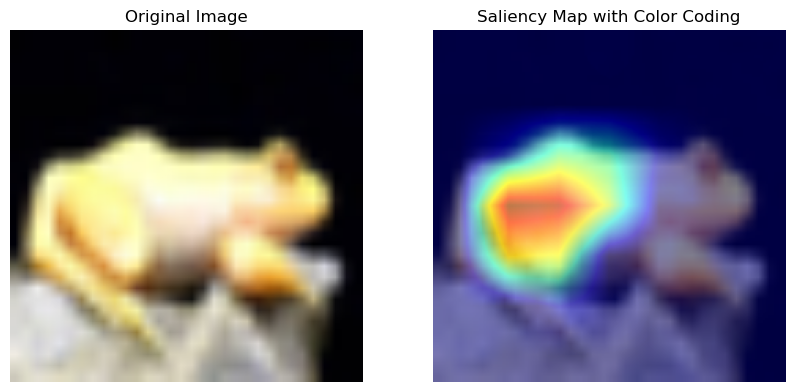

In [104]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# Load pre-trained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Sample image
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Generate saliency map using Grad-CAM
def generate_gradcam(input_image, model, target_class=None):
    target_layers = [model.layer4[-1]]  # Layer to visualize
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # Generate saliency map
    grayscale_cam = cam(input_tensor=input_image, targets=[ClassifierOutputTarget(target_class)])
    return grayscale_cam[0]

# Generate saliency map for the first image in the batch
saliency_map = generate_gradcam(images, model, labels[0].item())

# Convert the image to numpy array for overlay
image_np = np.transpose(images[0].numpy(), (1, 2, 0))

# Apply the saliency map on the image
cam_image = show_cam_on_image(image_np, saliency_map, use_rgb=True)

# Display the original image and the saliency map
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Saliency Map with Color Coding")
plt.imshow(cam_image)
plt.axis('off')

plt.show()

# Get ready to visualize the model's decision-making with stunning saliency maps, comparing ground truth with the areas the model finds most important!


Files already downloaded and verified


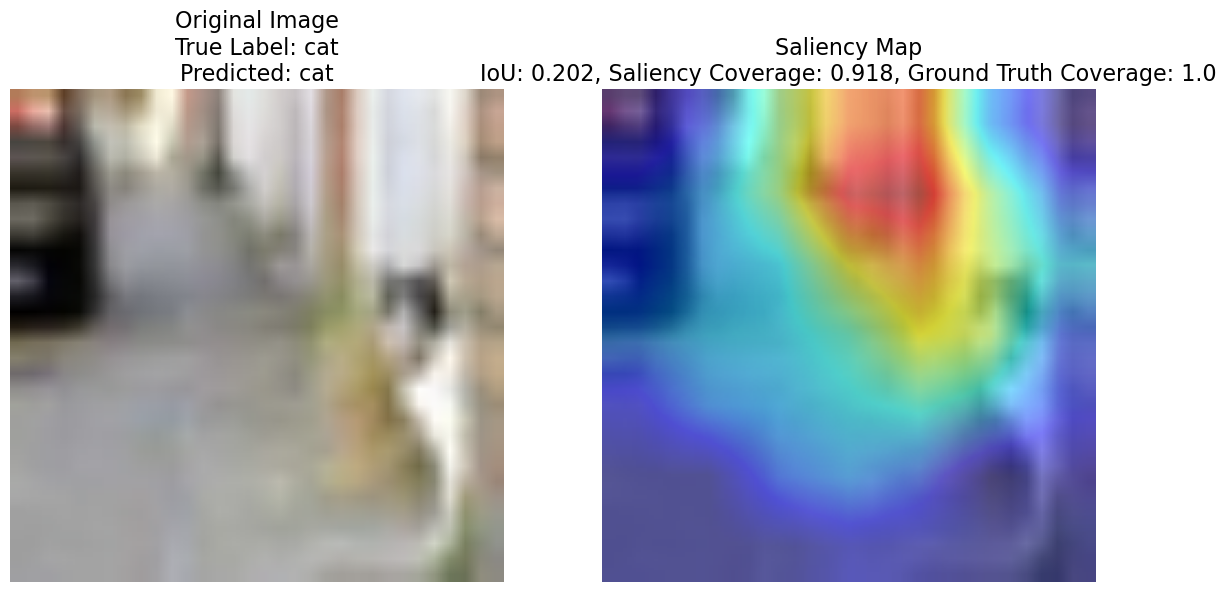

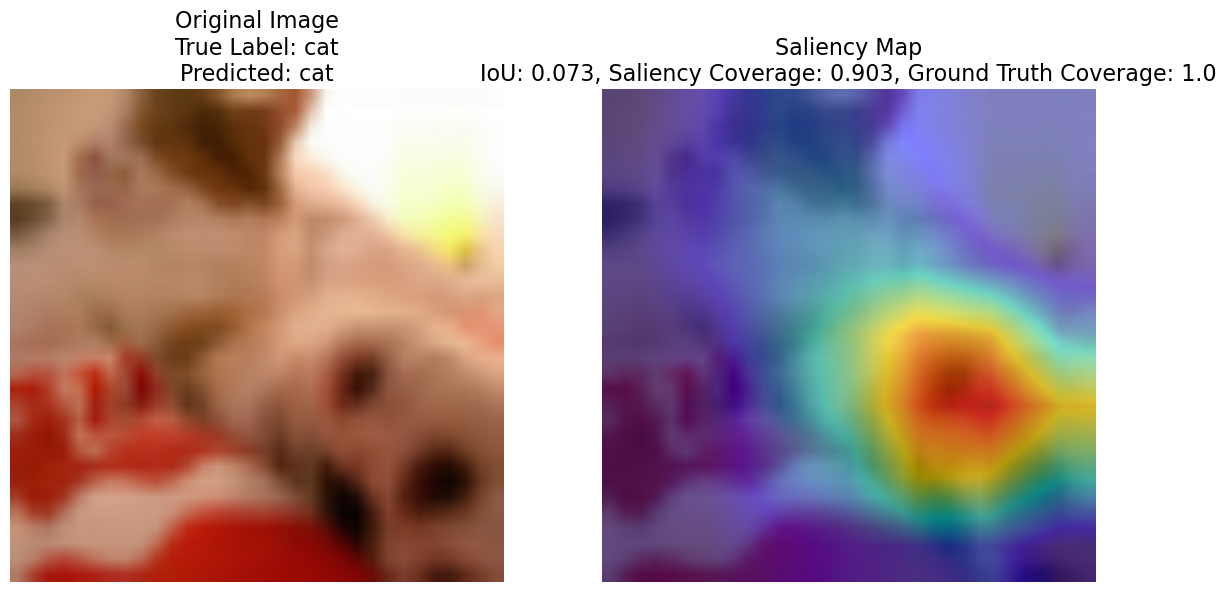

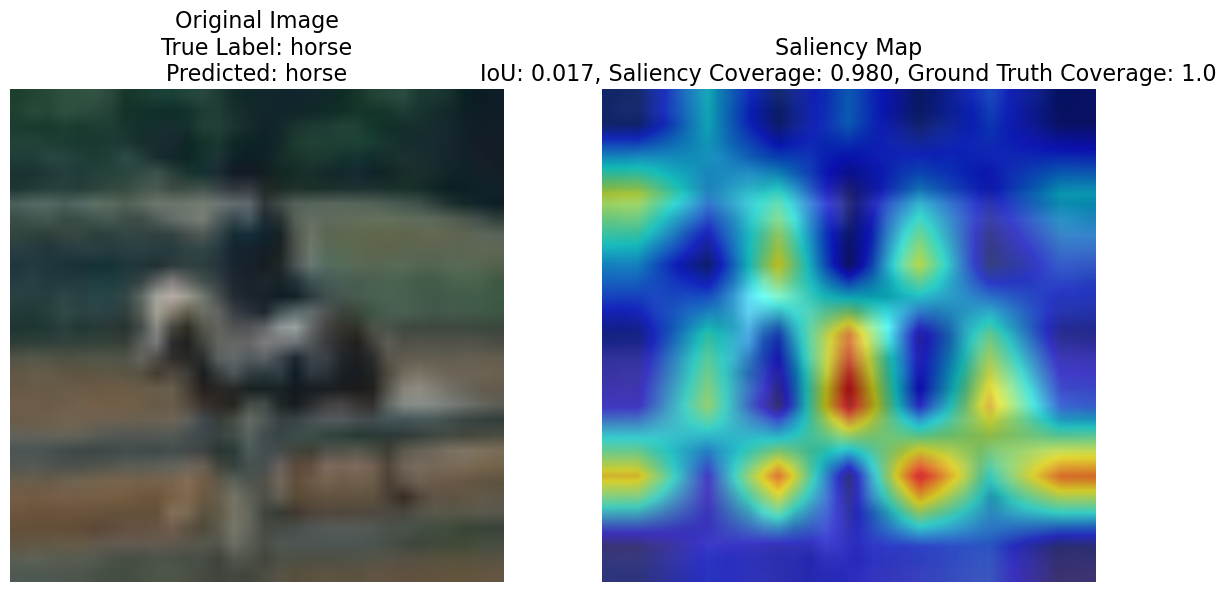

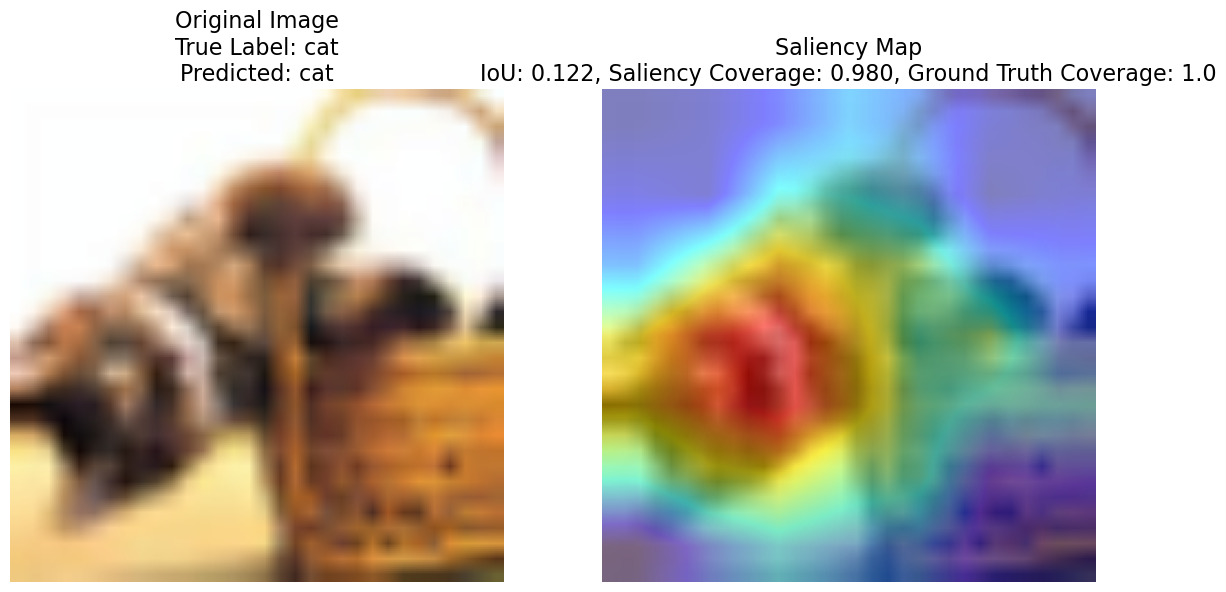

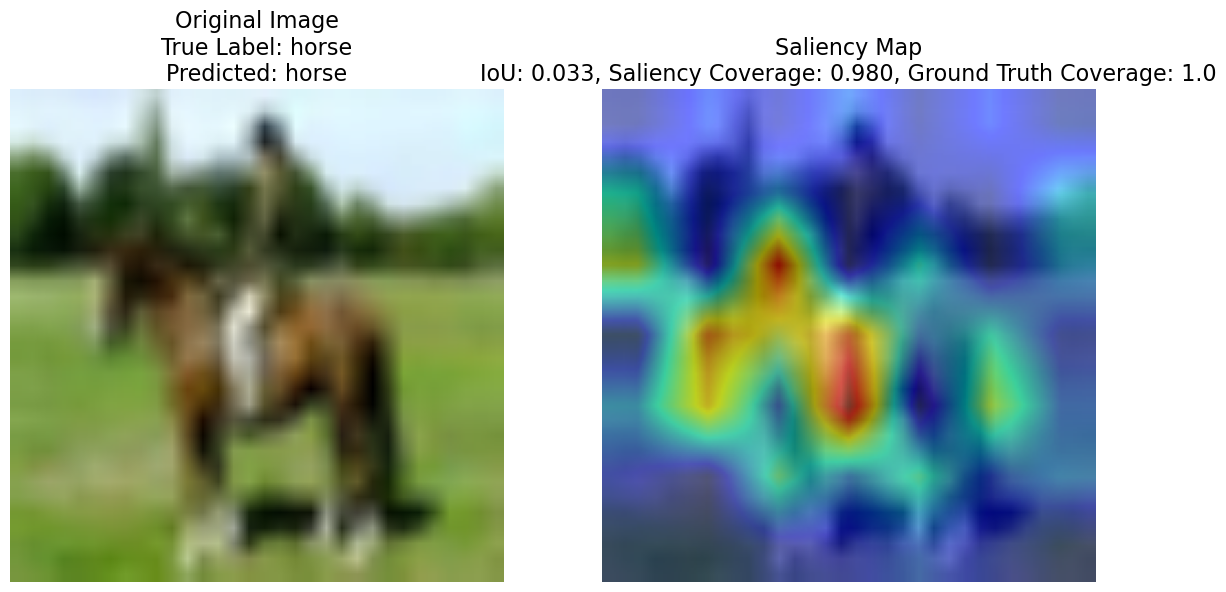

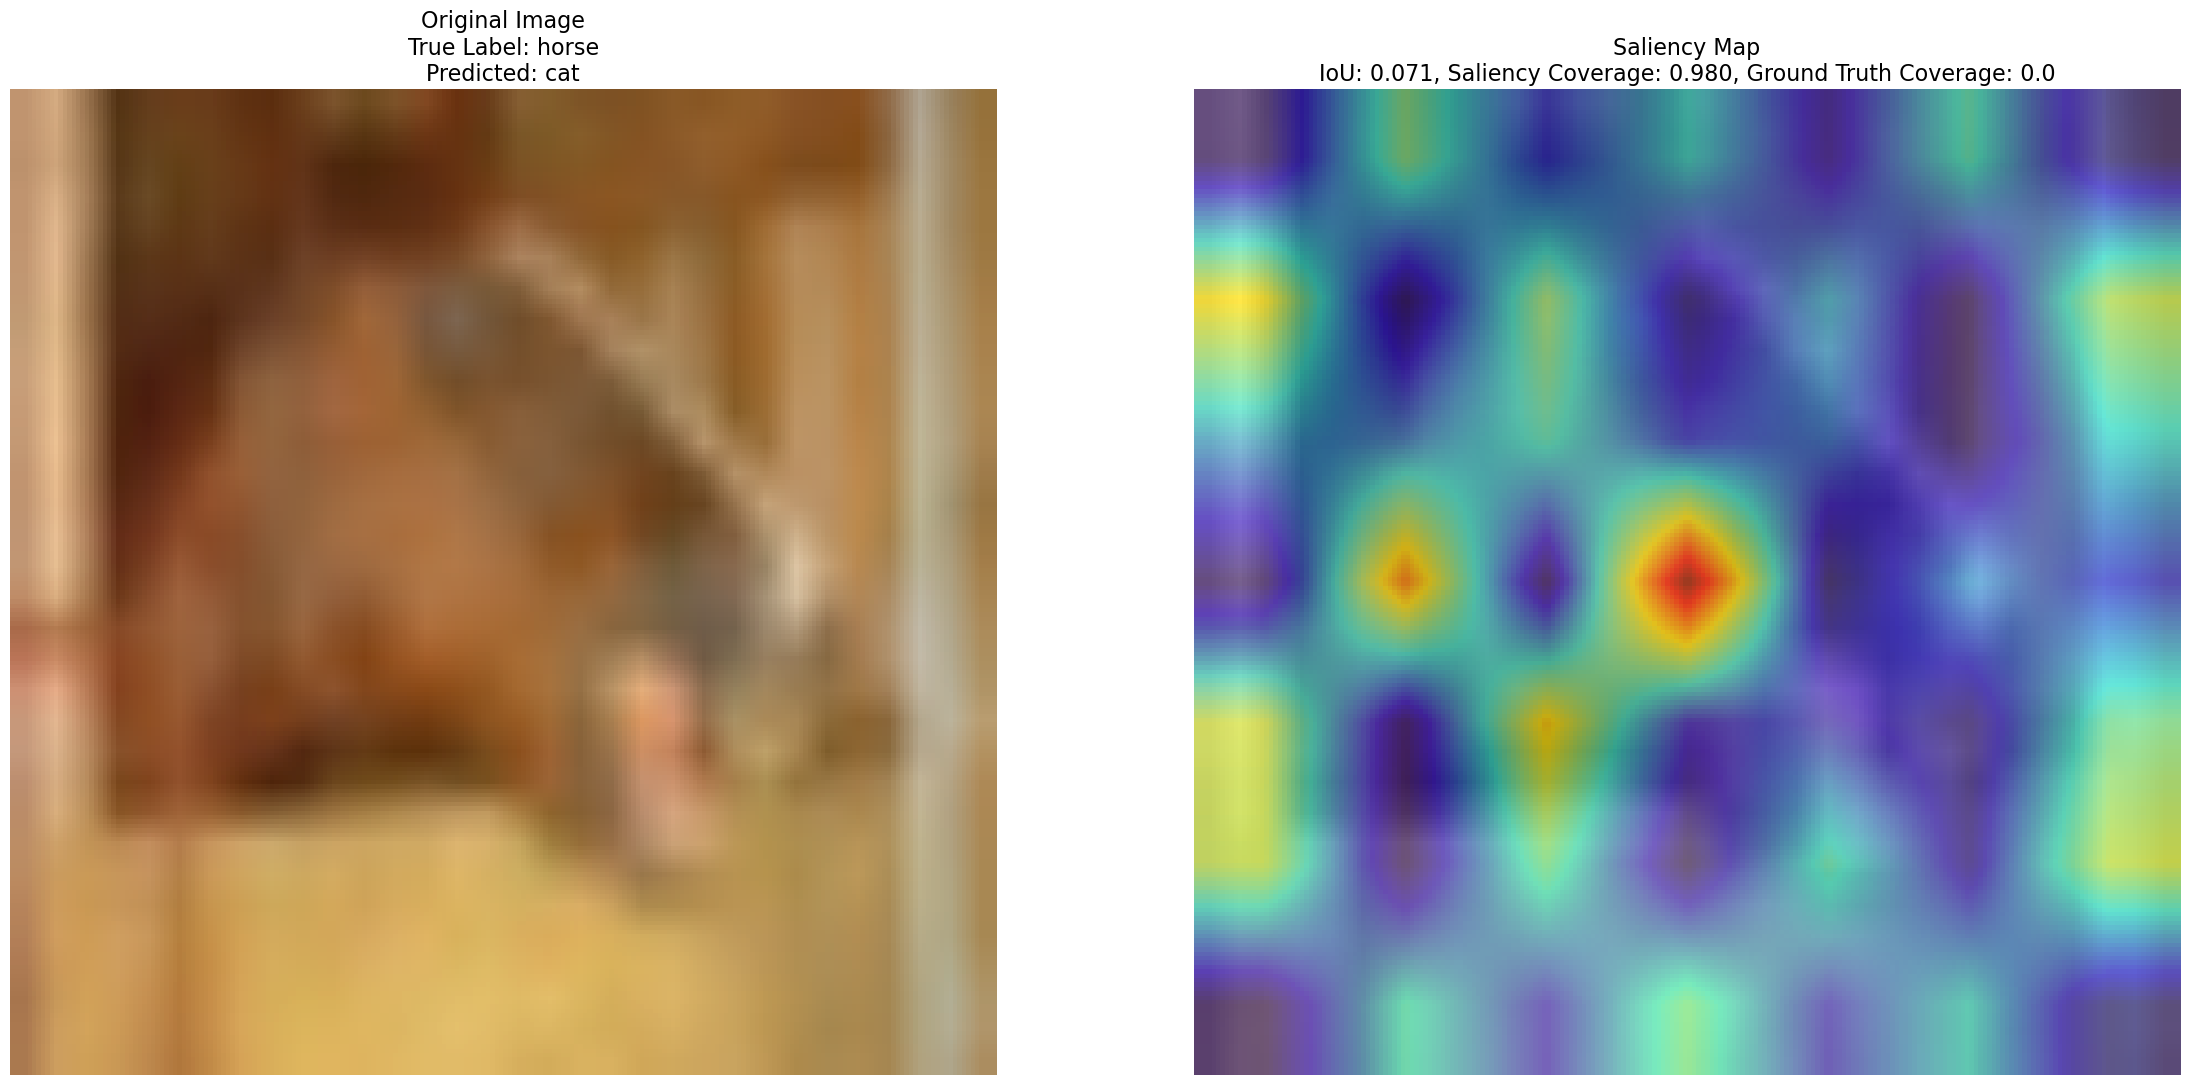

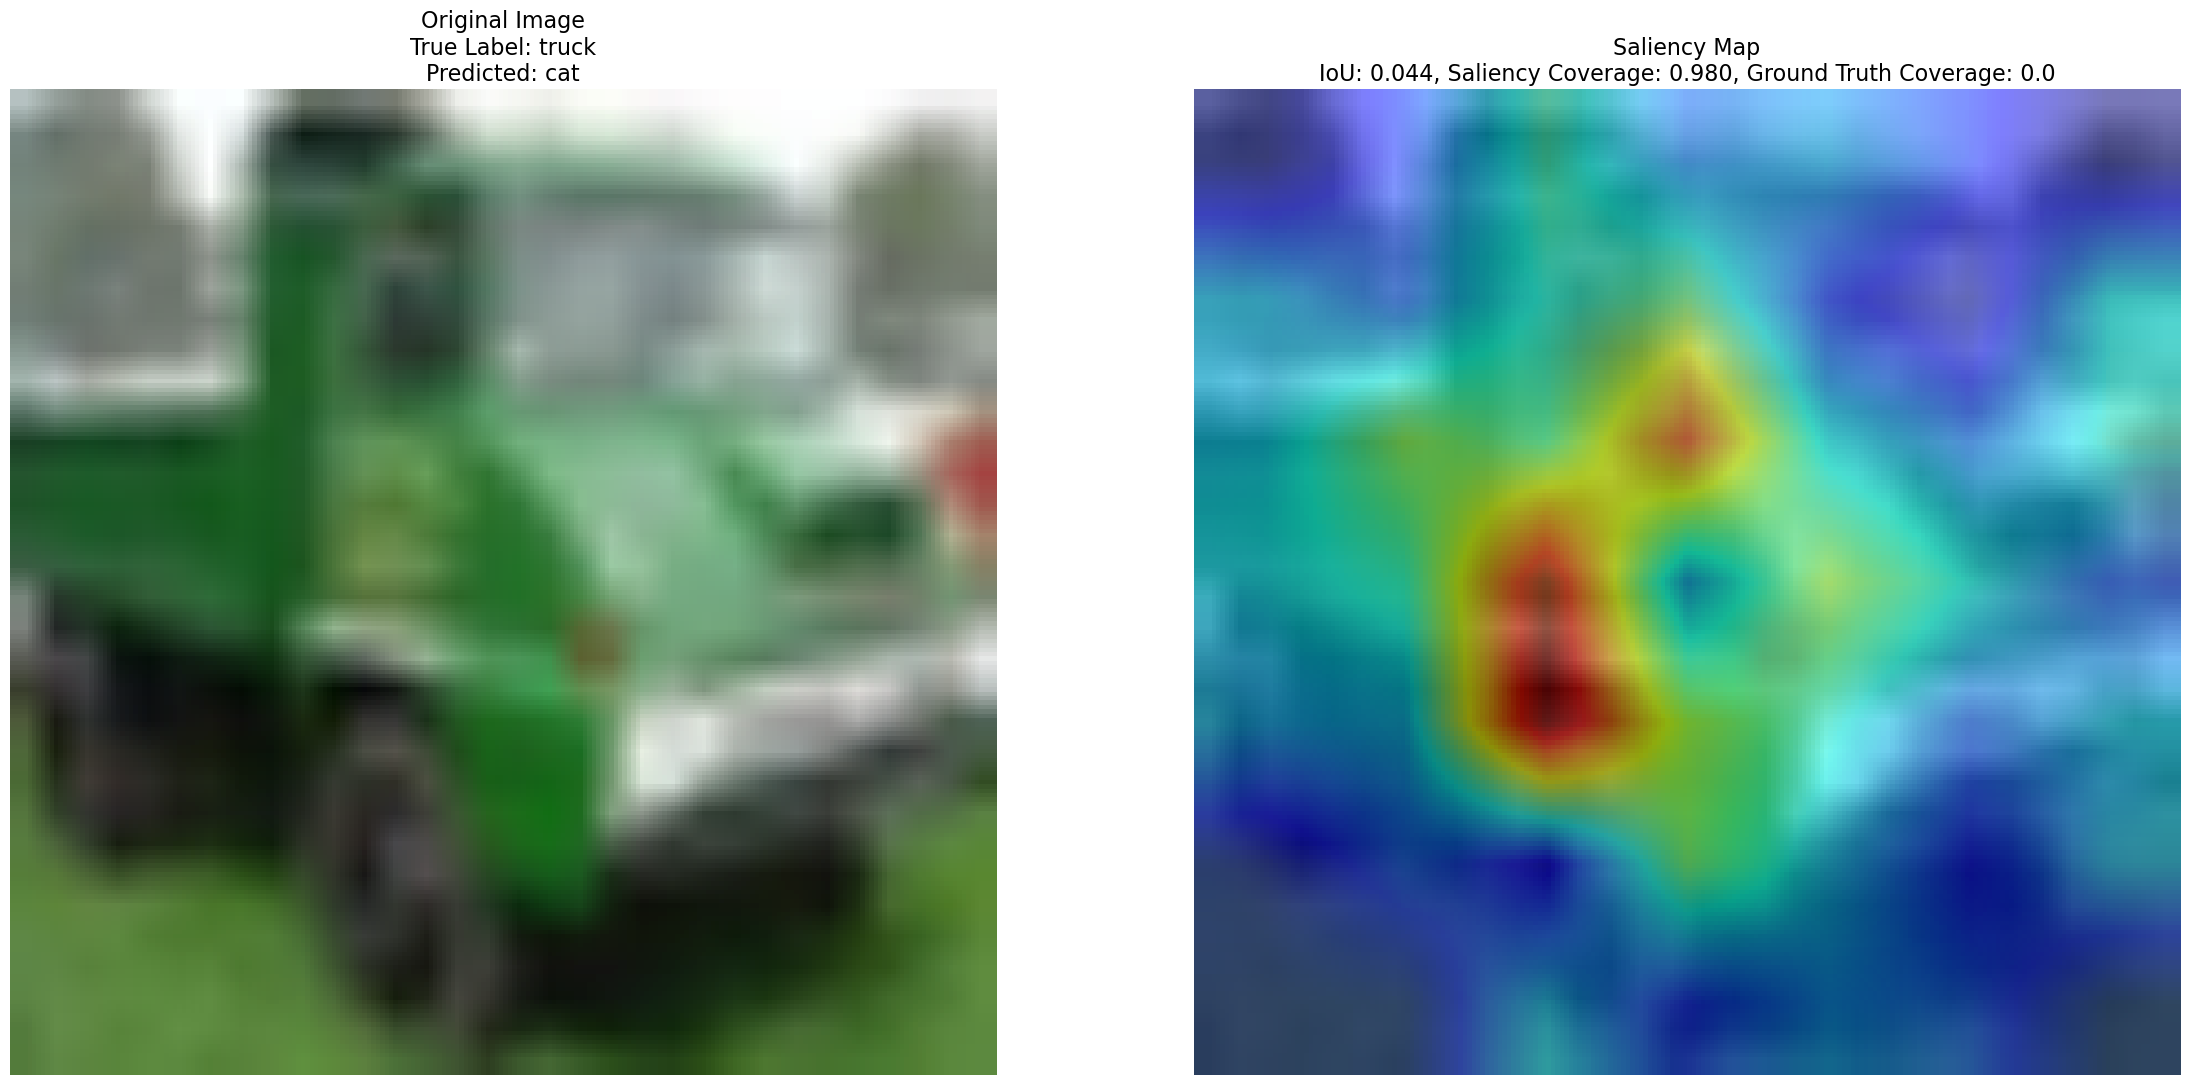

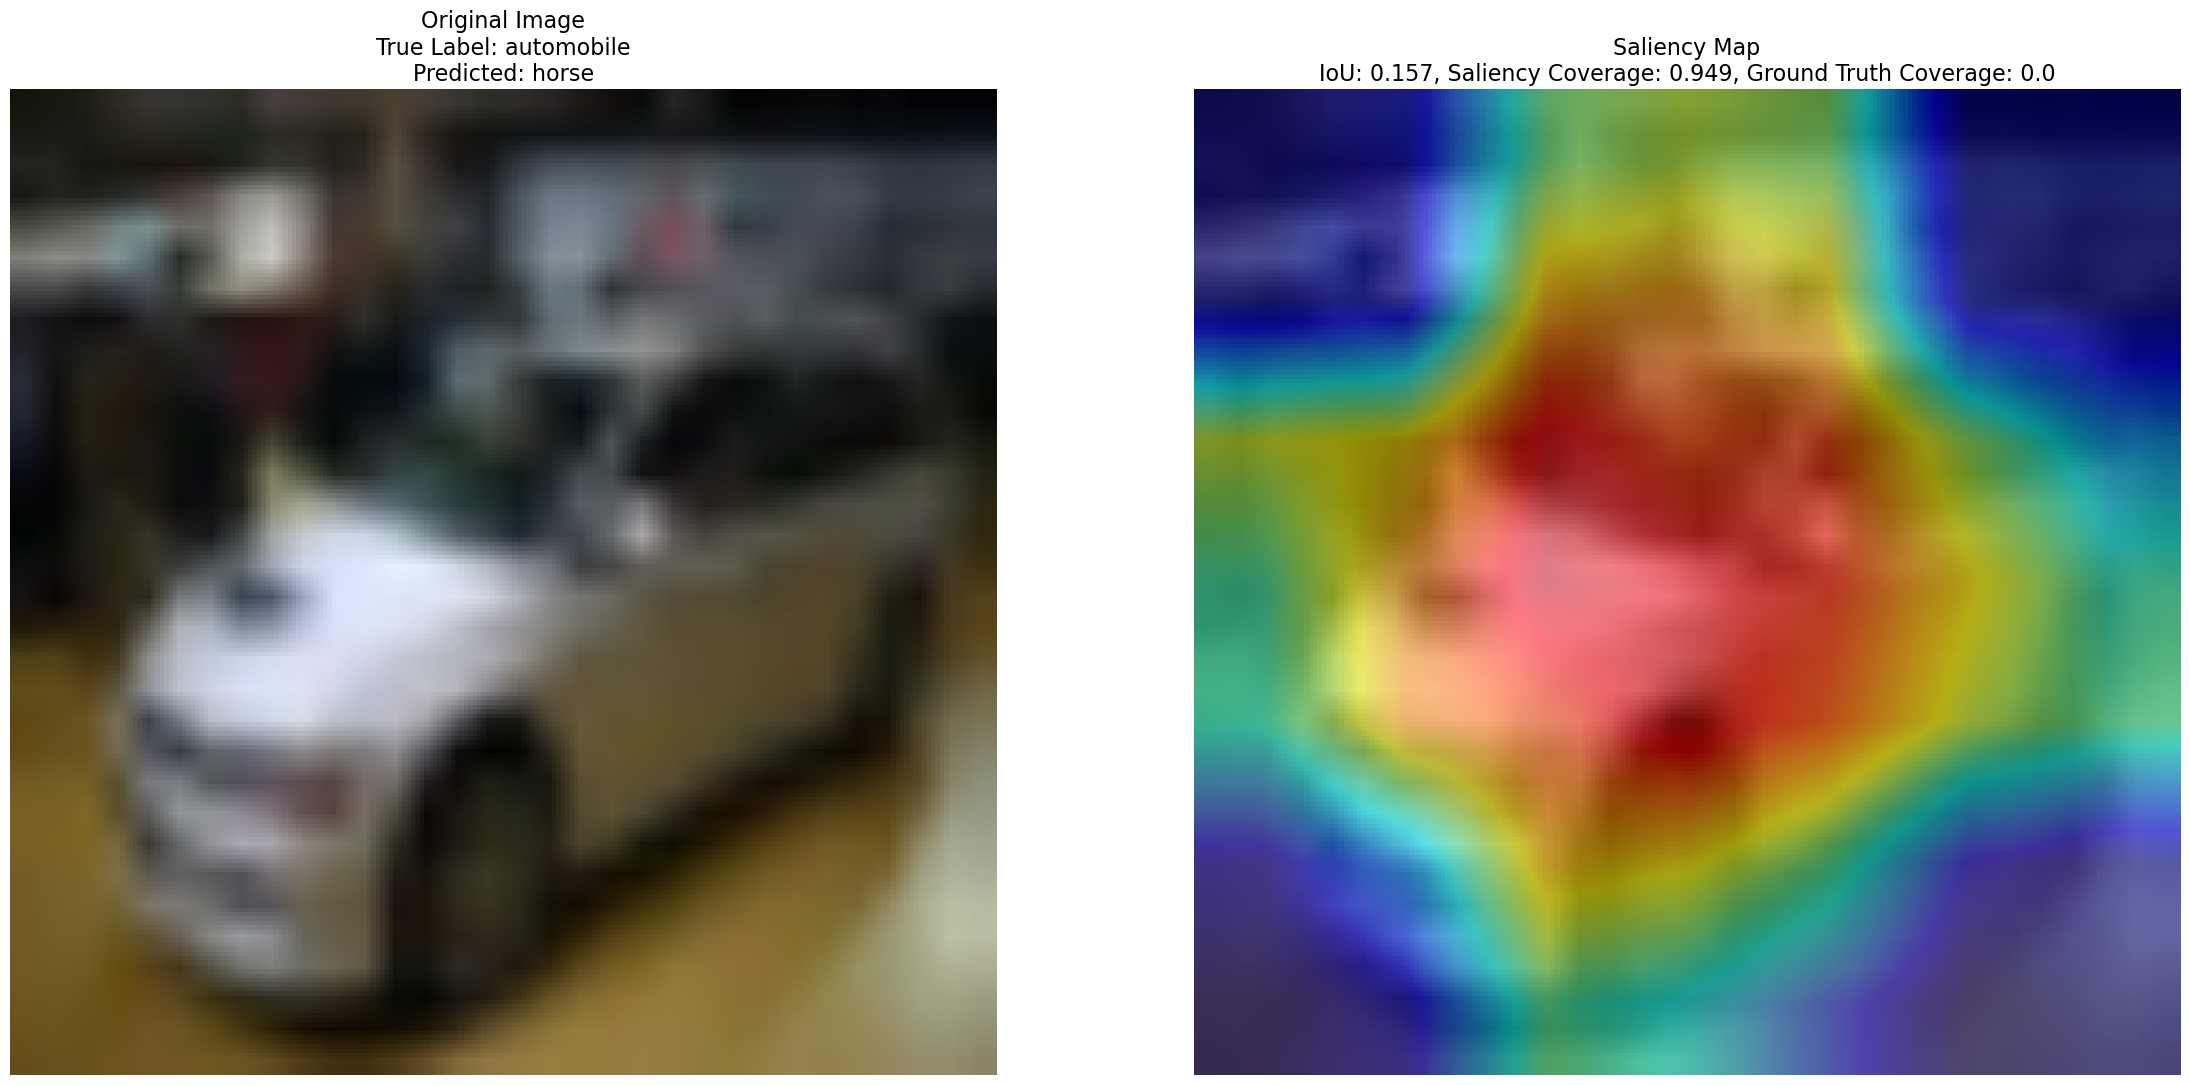

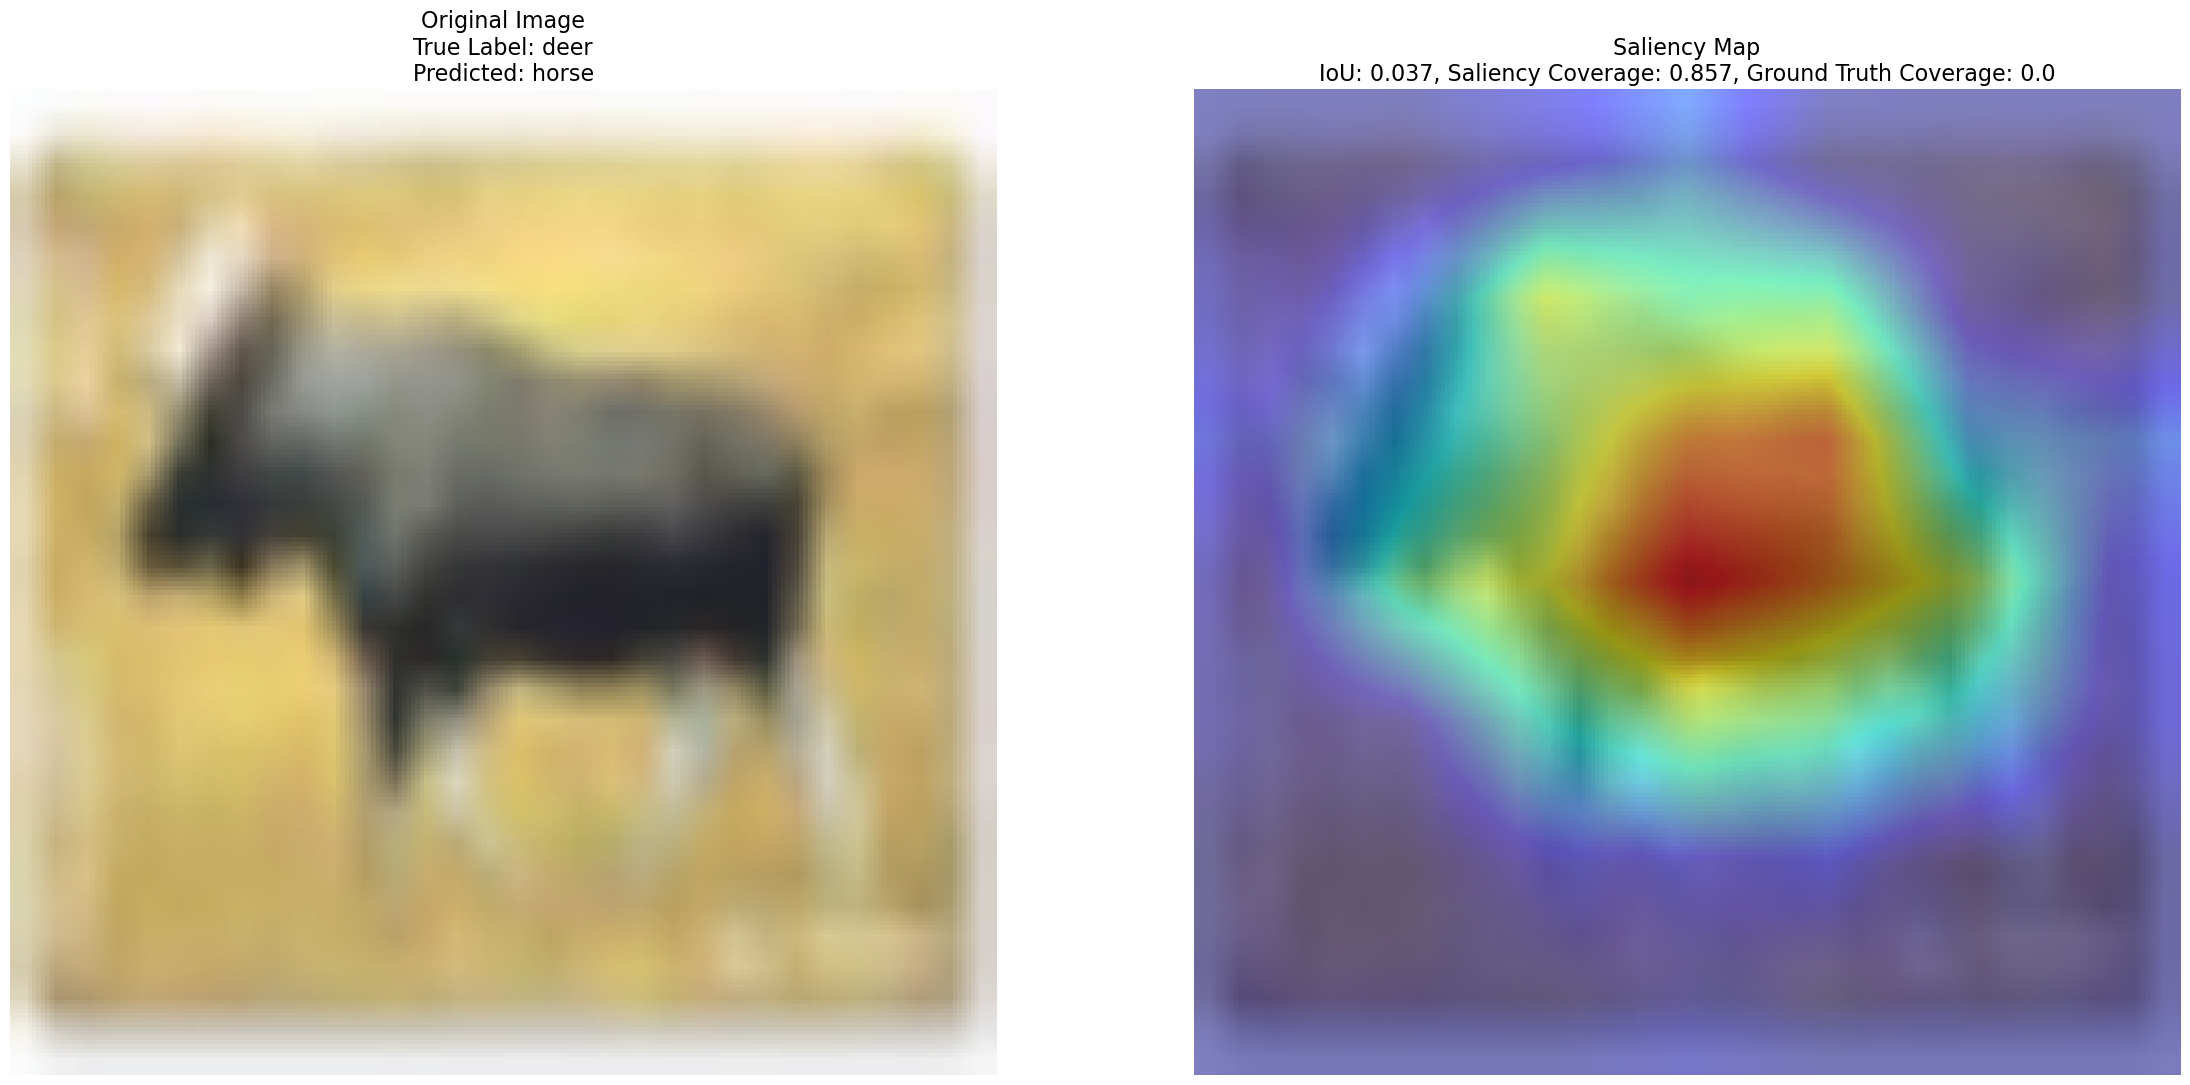

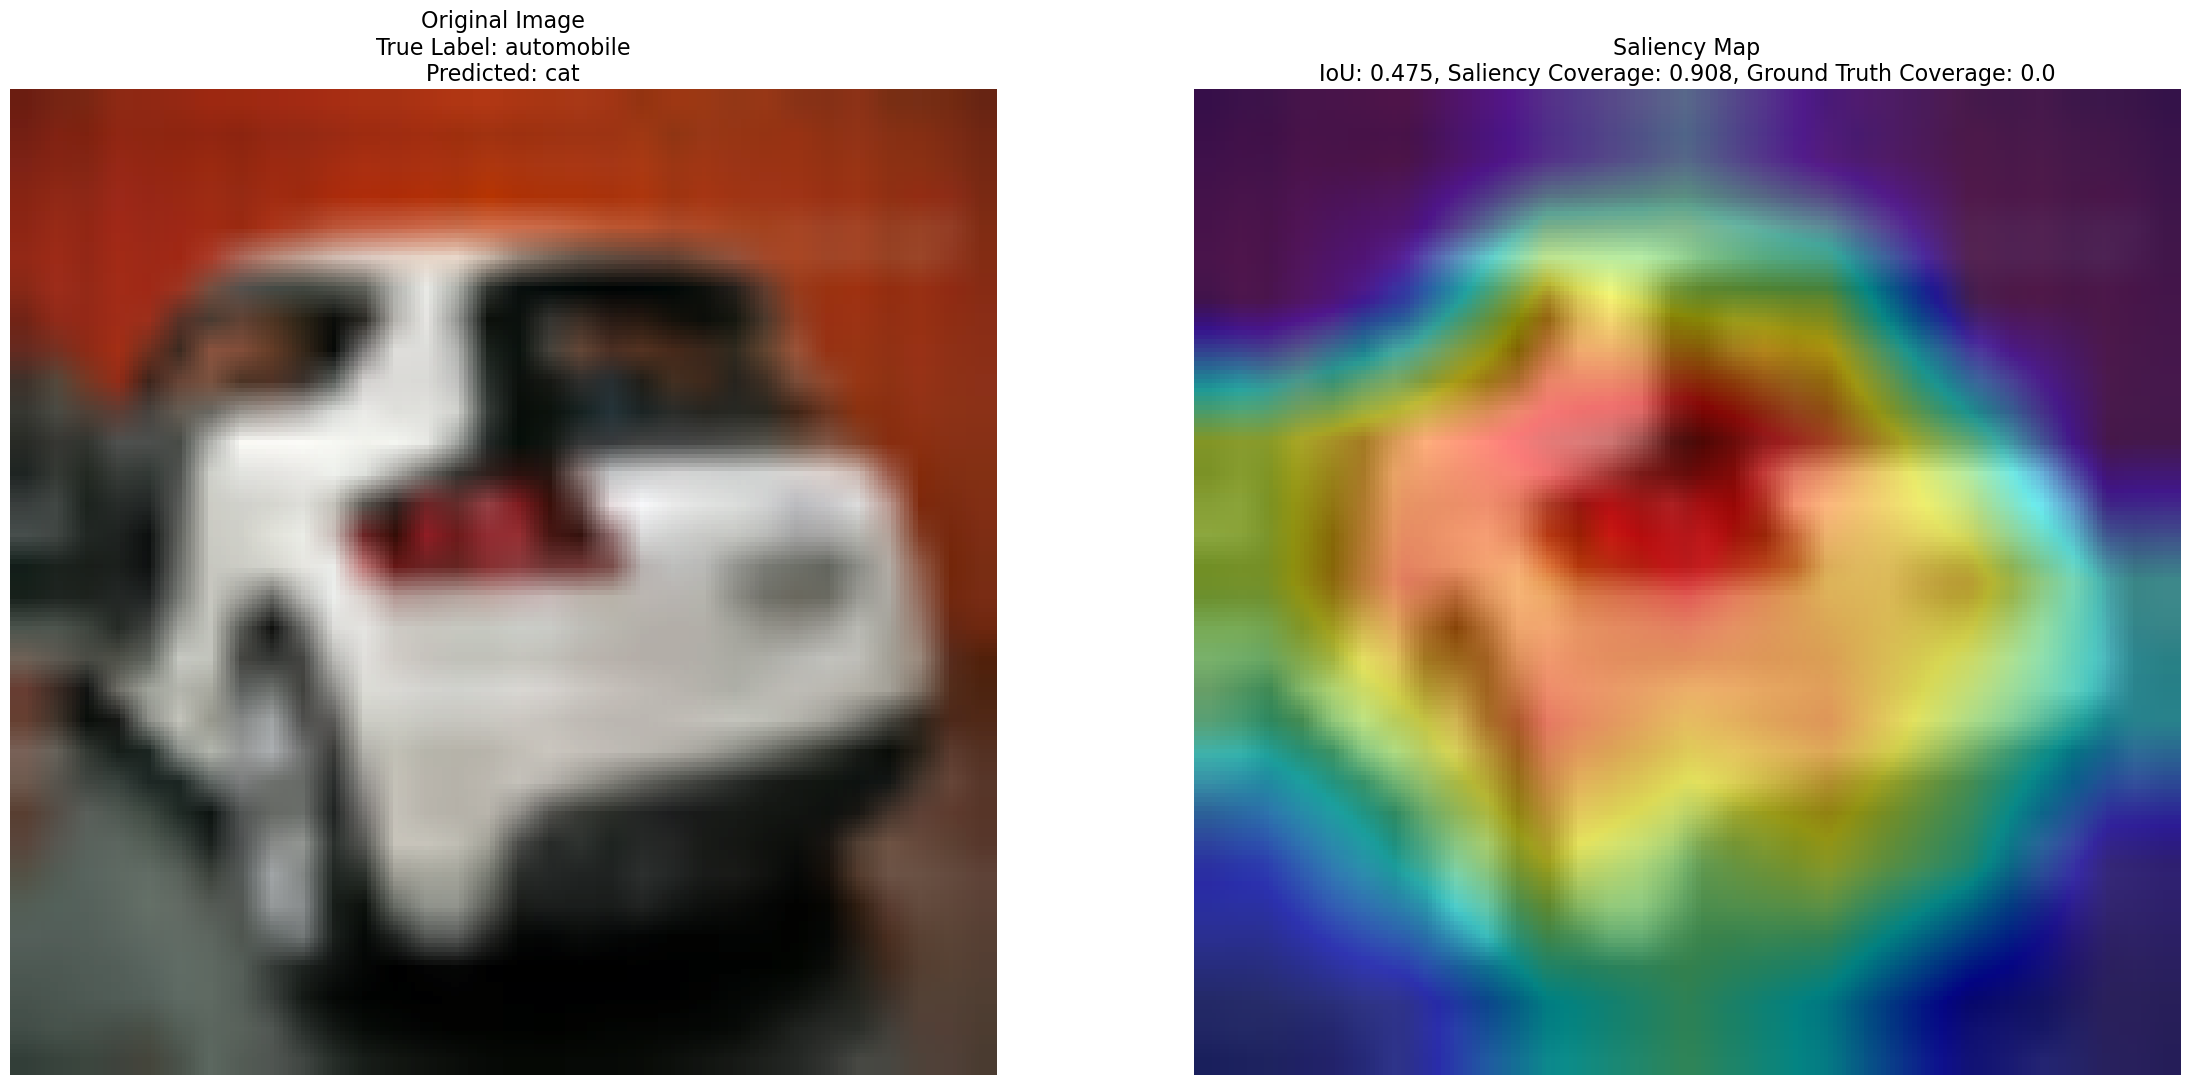

In [75]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# load the EfficientNet-B7 model pretrained on ImageNet with CIFAR-10 output classes
model = timm.create_model('tf_efficientnet_b7', pretrained=True, num_classes=10)
# set the model to evaluation mode
model.eval()

# define transformations to preprocess CIFAR-10 dataset images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # convert images to tensors
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize images using ImageNet means and std
])

# load the CIFAR-10 dataset and apply transformations
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# define CIFAR-10 class names
cifar10_class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# generate a saliency map using Grad-CAM
def generate_gradcam(input_image, model, target_class=None):
    # specify the last convolutional layer of the model to visualize
    target_layers = [model.blocks[-1][-1]]  # access the last block of the model
    # initialize GradCAM object
    cam = GradCAM(model=model, target_layers=target_layers)
    # generate the saliency map using GradCAM with smoothing techniques
    grayscale_cam = cam(input_tensor=input_image, targets=[ClassifierOutputTarget(target_class)], aug_smooth=True, eigen_smooth=True)
    return grayscale_cam[0]

# calculate IoU (Intersection over Union) between ground truth and saliency map
def calculate_iou(ground_truth, saliency_map):
    # convert ground truth to grayscale by averaging across the RGB channels
    ground_truth_gray = np.mean(ground_truth, axis=-1)
    # create a binary mask from the grayscale ground truth by thresholding
    ground_truth_binary = ground_truth_gray > 0.5  # adjust the threshold as needed
    # create a binary mask from the saliency map
    saliency_map_binary = saliency_map > 0.5
    # calculate intersection and union
    intersection = np.logical_and(ground_truth_binary, saliency_map_binary)
    union = np.logical_or(ground_truth_binary, saliency_map_binary)
    # compute IoU as the ratio of intersection to union
    iou = np.sum(intersection) / np.sum(union)
    return iou

# calculate saliency coverage (i.e., proportion of the image covered by the saliency map)
def calculate_coverage(saliency_map):
    # compute coverage as the fraction of pixels with non-zero saliency
    return np.sum(saliency_map > 0) / saliency_map.size

# initialize lists to store images and labels for correct and incorrect predictions
correct_images = []
incorrect_images = []
correct_labels = []
incorrect_labels = []
predicted_labels_correct = []
predicted_labels_incorrect = []

# test the model on a small subset of images (50 in this case)
for i, (images, labels) in enumerate(test_loader):
    if i >= 10:  # limit the number of tested images
        break
    # get the model's predictions for the current batch of images
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # check if the prediction matches the true label
    if predicted.item() == labels.item():
        # store correct predictions
        correct_images.append(images[0])
        correct_labels.append(labels[0].item())
        predicted_labels_correct.append(predicted.item())
    else:
        # store incorrect predictions
        incorrect_images.append(images[0])
        incorrect_labels.append(labels[0].item())
        predicted_labels_incorrect.append(predicted.item())

# display correct predictions with saliency maps
for i in range(len(correct_images)):
    # generate saliency map for the correct image
    saliency_map = generate_gradcam(correct_images[i].unsqueeze(0), model, correct_labels[i])
    
    # convert the image to a numpy array for display
    image_np = np.transpose(correct_images[i].numpy(), (1, 2, 0))
    # un-normalize the image to visualize it properly
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)  # clip values to keep them within valid range

    # overlay the saliency map on the original image
    cam_image = show_cam_on_image(image_np, saliency_map, use_rgb=True)

    # calculate the IoU, saliency coverage, and ground truth coverage
    iou = calculate_iou(image_np, saliency_map)
    saliency_coverage = calculate_coverage(saliency_map)
    ground_truth_coverage = 1.0  # for correct predictions, we assume full ground truth coverage

    # increase the size of the figure for better visualization
    plt.figure(figsize=(14, 7))

    # display the original image with its label
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\nTrue Label: {cifar10_class_names[correct_labels[i]]}\nPredicted: {cifar10_class_names[predicted_labels_correct[i]]}", fontsize=16)
    plt.imshow(image_np)
    plt.axis('off')

    # display the saliency map
    plt.subplot(1, 2, 2)
    plt.title(f"Saliency Map\nIoU: {iou:.3f}, Saliency Coverage: {saliency_coverage:.3f}, Ground Truth Coverage: {ground_truth_coverage}", fontsize=16)
    plt.imshow(cam_image)
    plt.axis('off')

    plt.show()

# display incorrect predictions with saliency maps
for i in range(len(incorrect_images)):
    # generate saliency map for the incorrect image
    saliency_map = generate_gradcam(incorrect_images[i].unsqueeze(0), model, incorrect_labels[i])
    
    # convert the image to a numpy array for display
    image_np = np.transpose(incorrect_images[i].numpy(), (1, 2, 0))
    # un-normalize the image to visualize it properly
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)  # clip values to keep them within valid range

    # overlay the saliency map on the original image
    cam_image = show_cam_on_image(image_np, saliency_map, use_rgb=True)

    # calculate the IoU, saliency coverage, and ground truth coverage
    iou = calculate_iou(image_np, saliency_map)
    saliency_coverage = calculate_coverage(saliency_map)
    ground_truth_coverage = 0.0  # for incorrect predictions, we assume no ground truth coverage

    # increase the size of the figure for better visualization
    plt.figure(figsize=(28, 14))

    # display the original image with its label
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\nTrue Label: {cifar10_class_names[incorrect_labels[i]]}\nPredicted: {cifar10_class_names[predicted_labels_incorrect[i]]}", fontsize=16)
    plt.imshow(image_np)
    plt.axis('off')

    # display the saliency map
    plt.subplot(1, 2, 2)
    plt.title(f"Saliency Map\nIoU: {iou:.3f}, Saliency Coverage: {saliency_coverage:.3f}, Ground Truth Coverage: {ground_truth_coverage}", fontsize=16)
    plt.imshow(cam_image)
    plt.axis('off')

    plt.show()


#### The following research analysis derives from the paper "Shared Interest: Measuring Human-AI Alignment to Identify Recurring Patterns in Model Behavior" by Angie Boggust, Benjamin Hoover, Arvind Satyanarayan, and Hendrik Strobelt. The paper introduces the Shared Interest metrics, which compare model reasoning (via saliency) to human reasoning (via ground truth annotations), enabling systematic analysis of neural network behavior .

# References

Boggust, A., Hoover, B., Satyanarayan, A., & Strobelt, H. (2022). *Shared Interest: Measuring Human-AI Alignment to Identify Recurring Patterns in Model Behavior*. CHI Conference on Human Factors in Computing Systems, New Orleans, LA, USA. https://doi.org/10.1145/3491102.3501965
